In [4]:
!pip install ccxt

import ccxt
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt






Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
class DataReciever:
    def __init__(self, data_source):
        self.data_source = data_source
        if data_source == 'binance':
            self.api = ccxt.binance({
                'apiKey': '',
                'secret': '',
                'enableRateLimit': True,
            })

    def get_ohlcv(self, market, timeframe, data_samples):
        try:
            if self.data_source == 'binance':
                ohlcv = self.api.fetch_ohlcv(market, timeframe=timeframe, limit = data_samples)
            return {
            'market': market,
            'ohlcv': ohlcv
            }
        except Exception as e:
            print(e)
            return None

    def create_df(self, ohlcv):
        df = pd.DataFrame(data = ohlcv['ohlcv'], columns = ['timestamp',
                                                   'open',
                                                   'high',
                                                   'low',
                                                   'close',
                                                   'volume'])
        result = {
        'market': ohlcv['market'],
        'df': df
        }
        return result

    def convert_time(self, data):
        for index, row in data['df'].iterrows():
            data['df'].at[index,'timestamp'] = datetime.fromtimestamp(row['timestamp'] / 1000)
        result = {
        'market': data['market'],
        'df': data['df']
        }
        return result

    def run(self, asset, benchmark, timeframe, data_samples):
        asset_ohlcv = self.get_ohlcv(asset, timeframe, data_samples)
        benchmark_ohlcv = self.get_ohlcv(benchmark, timeframe, data_samples)

        asset_df = self.create_df(asset_ohlcv)
        benchmark_df = self.create_df(benchmark_ohlcv)

        asset_df = self.convert_time(asset_df)
        benchmark_df = self.convert_time(benchmark_df)

        return asset_df, benchmark_df

In [23]:
class DataAnalyzer:
    def __init__(self, asset_df, benchmark_df, window):
        self.asset_df = asset_df
        self.benchmark_df = benchmark_df
        self.window = window

    def plot(self, data, column1, column2):
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.plot(data['df']['timestamp'], data['df'][column1], color=color,  lw = 2)
        ax1.tick_params(axis='y', labelcolor=color)

        color = 'tab:red'
        ax2 = ax1.twinx()
        ax2.plot(data['df']['timestamp'], data['df'][column2], color=color,  lw = 1)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.show()

    def calc_sharpe_ratio(self, data, rf):
        data['df']['log_return'] = np.log(data['df']['close'] / data['df']['close'].shift(1))
        data['df']['volatility'] = data['df']['log_return'].rolling(window = 252).std() * np.sqrt(252)
        data['df']['sharpe_ratio'] = (data['df']['log_return'].mean() - rf) / data['df']['volatility']
        self.plot(data, 'close', 'sharpe_ratio')

    def calc_information_ratio(self, window):
        self.asset_df['df']['log_return'] = np.log(self.asset_df['df']['close'] / self.asset_df['df']['close'].shift(1))
        self.benchmark_df['df']['log_return'] = np.log(self.benchmark_df['df']['close'] / self.benchmark_df['df']['close'].shift(1))
        self.asset_df['df']['return_difference_vs_benchmark'] = self.asset_df['df']['log_return'] - self.benchmark_df['df']['log_return']
        self.asset_df['df']['volatility'] = self.asset_df['df']['return_difference_vs_benchmark'].std() * np.sqrt(window)
        self.asset_df['df']['information_ratio'] = self.asset_df['df']['return_difference_vs_benchmark'].mean() / self.asset_df['df']['volatility']
        self.plot(self.asset_df, 'close', 'information_ratio')

    def calc_modigliani_ratio(self, rf, window):
        self.asset_df['df']['log_return'] = np.log(self.asset_df['df']['close'] / self.asset_df['df']['close'].shift(1))
        self.asset_df['df']['volatility'] = self.asset_df['df']['log_return'].std() * np.sqrt(window)
        self.asset_df['df']['sharpe_ratio'] = (self.asset_df['df']['log_return'].mean() - rf) / self.asset_df['df']['volatility']

        self.benchmark_df['df']['log_return'] = np.log(self.benchmark_df['df']['close'] / self.benchmark_df['df']['close'].shift(1))
        self.benchmark_df['df']['volatility'] = self.benchmark_df['df']['log_return'].std() * np.sqrt(window)

        self.asset_df['df']['m2_ratio'] = (self.asset_df['df']['sharpe_ratio'] * self.benchmark_df['df']['volatility']) + rf

        self.plot(self.asset_df, 'close', 'm2_ratio')

   


In [24]:
data_source = 'binance'
asset = 'ETH/USDT'
benchmark = 'BTC/USDT'
timeframe = '1d'
data_samples = 365
dr = DataReciever(data_source)
asset_df, benchmark_df = dr.run(asset, benchmark, timeframe, data_samples)
print('data recieved')
da = DataAnalyzer(asset_df, benchmark_df, window = data_samples)

data recieved


Sharpe ratio. 

Shows how much risk investor takes to take profit. Small volatility is the best when profits are equal. 

Ratio is calculates as: log_returns / volatility

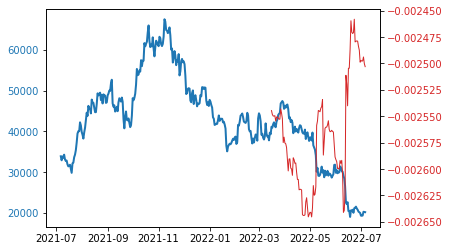

In [25]:
da.calc_sharpe_ratio(benchmark_df, rf = 0)

The information ratio is an extension of the Sharpe ratio which replaces the risk-free rate of return with the returns of a benchmark portfolio. It measures a trader’s ability to generate excess returns relative to a benchmark.

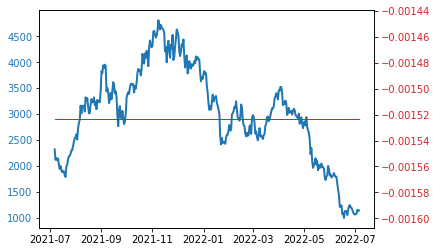

In [26]:
da.calc_information_ratio(window = 252)

The Modigliani ratio measures the returns of the portfolio, adjusted for the risk of the portfolio relative to that of some benchmark.
To calculate the M2 ratio, we first calculate the Sharpe ratio and then multiply it by the annualized standard deviation of a chosen benchmark. We then add the risk-free rate to the derived value to give M2 ratio.

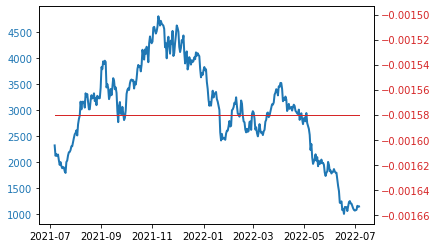

In [27]:
da.calc_modigliani_ratio(rf = 0, window = 252)